Start with our usual setup, including the utility methods from last time.

In [1]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from time import time

# Make matplotlib figures appear inline in the
# notebook rather than in a new window
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def display(img, title=None):
    # Show image
    plt.figure(figsize = (5,5))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

Optional: we'll use the OpenCV library's convolution function, which is much faster. You may need to run `pip3 install opencv-python` and restart Jupyter notebook.

In [2]:
import cv2

We'll start by reviewing the example from lecture: the iguana and the horizontal derivative.

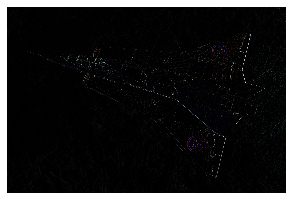

In [3]:
filter = np.array(
[
    [1,0,-1]
])

image = cv2.imread('../Filters/draken.jpg')
# image = cv2.imread('/home/daniel/Downloads/gus.jpg')
result = cv2.filter2D(image, -1, filter)
display(result)

# Exercise 1
Let's try and address some of the problems that we found in lecture.

1. The image is dark, and it's hard to tell where the edges are that we found. How can we improve on this? Can we do this in a single filter?
2. The algorithm finds lots of edges, but we don't care about all of them. Could we keep only the brightest edges somehow? 
3. We used a horizontal derivative filter. Create and run a vertical derivative filter. Should it look similar? Does it? Find an image where the horizontal and vertical derivative filters produce very different output.
4. How does the derivative filter respond to noise? Load and run the filter on the noisy_einstein image. Can you improve on this result?


brightened: 


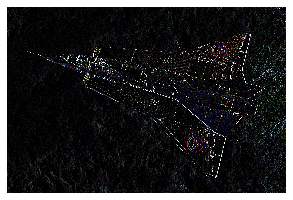

In [4]:
# brightening the image in a single filter: just multiply the filter by a scalar
brt_factor = 5
print("brightened: ")
display(cv2.filter2D(image, -1, brt_factor * filter)) # second arg is the depth of the output image?

single threshold: 


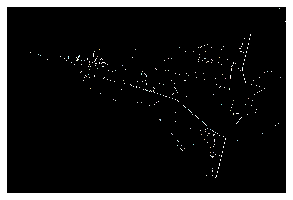

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


canny: 


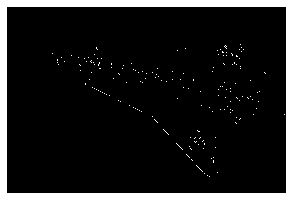

In [5]:
# keep only the brightest edges - single threshold?
new_img = cv2.filter2D(image, -1, brt_factor * filter)
thresh = 200
for i_y, y in enumerate(new_img):
    for i_x, x in enumerate(y):
        if np.mean(new_img[i_y][i_x]) < thresh:
            new_img[i_y][i_x] = [0, 0, 0]
print("single threshold: ")
display(new_img) # I mean it kind of works but its not ideal


# keep only the brightest edges - canny edge detector? https://en.wikipedia.org/wiki/Canny_edge_detector#Process_of_Canny_edge_detection_algorithm

# de noise with gaussian blur
new_img = cv2.GaussianBlur(image, (15, 15), 2) # src, kernel size, sigma

# find the intensity of the gradient (so horiz and vert derivatives)
# want to find horizontal, vertical, and diagonal edges
def snap_dir(angle): # angle in range -pi to pi
    return np.round(np.degrees(angle) / 45) * 45 % 180
# run an edge detection filter (sobel) to find first derivatives in the x and y directions
v_filter = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1],
])
h_filter = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1],
])
v_derivative = cv2.filter2D(new_img, -1, v_filter)
h_derivative = cv2.filter2D(new_img, -1, h_filter)
# for each pixel, find the magnitude of the gradient and the direction of the gradient
mags = np.zeros((new_img.shape[0], new_img.shape[1], 3))
dirs = mags.copy()
for i_y, y in enumerate(new_img):
    for i_x, x in enumerate(y):
        mags[i_y][i_x] = np.hypot(v_derivative[i_y][i_x], h_derivative[i_y][i_x])
        dirs[i_y][i_x] = snap_dir(np.arctan2(v_derivative[i_y][i_x], h_derivative[i_y][i_x]))
# not maximum suppression
padded_mags = np.pad(mags, 1)
padded_dirs = np.pad(dirs, 1)
# I'm fed up with this image being 3 channel
new_img = np.zeros((new_img.shape[0], new_img.shape[1]))
# ok back to non max suppression
for i in range(1, len(padded_mags) - 1):
    for j in range(1, len(padded_mags[0]) - 1):
        grad = np.mean(padded_mags[i][j]) # assuming the image is b/w
        dir_ = np.mean(padded_dirs[i][j])
        if dir_ == 0: # check if grad > left and right
            if grad > np.mean(padded_mags[i][j - 1]) and grad > np.mean(padded_mags[i][j + 1]):
                new_img[i - 1][j - 1] = grad
            else:
                new_img[i - 1][j - 1] = 0
        elif dir_ == 90: # check if grad > top and bottom
            if grad > np.mean(padded_mags[i - 1][j]) and grad > np.mean(padded_mags[i + 1][j]):
                new_img[i - 1][j - 1] = grad
            else:
                new_img[i - 1][j - 1] = 0
        elif dir_ == 135: # check if grad > top left and bottom right
            if grad > np.mean(padded_mags[i - 1][j - 1]) and grad > np.mean(padded_mags[i + 1][j + 1]):
                new_img[i - 1][j - 1] = grad
            else:
                new_img[i - 1][j - 1] = 0
        else: # 45, check if grad > top right and bottom left
            if grad > np.mean(padded_mags[i - 1][j + 1]) and grad > np.mean(padded_mags[i + 1][j - 1]):
                new_img[i - 1][j - 1] = grad
            else:
                new_img[i - 1][j - 1] = 0
# double threshold:
low = 5
high = 40
# below low = suppress (0), between = weak (1), above high = strong (2)
for i_y, y in enumerate(new_img):
    for i_x, x in enumerate(y):
        if x < low:
            new_img[i_y][i_x] = 0
        elif x < high:
            new_img[i_y][i_x] = 1
        else:
            new_img[i_y][i_x] = 2

def weak_pixel_count():
    count = 0
    for i_y, y in enumerate(new_img):
        for i_x, x in enumerate(y):
            if x == 1:
                count += 1
    return count

# hysteresis: if a strong pixel is touching a weak pixel make the weak strong. 
# iterate until weak count stays same and remove remaining weak
while weak_pixel_count() > 0:
    previous_count = weak_pixel_count()
    for i_y, y in enumerate(new_img):
        for i_x, x in enumerate(y):
            if x == 1:
                # top left
                if i_y > 0 and i_x > 0:
                    if new_img[i_y - 1][i_x - 1] == 2:
                        new_img[i_y][i_x] = 2
                # top
                if i_y > 0:
                    if new_img[i_y - 1][i_x] == 2:
                        new_img[i_y][i_x] = 2
                # top right
                if i_y > 0 and i_x < len(y) - 1:
                    if new_img[i_y - 1][i_x + 1] == 2:
                        new_img[i_y][i_x] = 2
                # middle left
                if i_x > 0:
                    if new_img[i_y][i_x - 1] == 2:
                        new_img[i_y][i_x] = 2
                # middle (skip)
                # middle right
                if i_x < len(y) - 1:
                    if new_img[i_y][i_x + 1] == 2:
                        new_img[i_y][i_x] = 2
                # bottom left
                if i_y < len(new_img) - 1 and i_x < len(y) - 1:
                    if new_img[i_y + 1][i_x - 1] == 2:
                        new_img[i_y][i_x] = 2
                # bottom
                if i_y < len(new_img) - 1:
                    if new_img[i_y + 1][i_x] == 2:
                        new_img[i_y][i_x] = 2
                # bottom right
                if i_y < len(new_img) - 1 and i_x < len(y) - 1:
                    if new_img[i_y + 1][i_x + 1] == 2:
                        new_img[i_y][i_x] = 2
                        
    if previous_count == weak_pixel_count():
        for i_y, y in enumerate(new_img):
            for i_x, x in enumerate(y):
                if x == 1:
                    new_img[i_y][i_x] = 0
        break

# rgb ify
final_img = np.zeros((new_img.shape[0], new_img.shape[1], 3))
for i_y, y in enumerate(new_img):
    for i_x, x in enumerate(y):
        final_img[i_y][i_x] = np.array([x, x, x])
        
print("canny: ")
display(final_img)


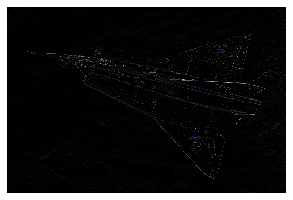

In [9]:
# vertical filter
filter = np.array(
[
    1,0,-1
])

image = cv2.imread('../Filters/draken.jpg')
# image = cv2.imread('/home/daniel/Downloads/gus.jpg')
result = cv2.filter2D(image, -1, filter)
display(result)

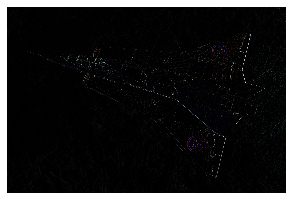

In [10]:
# horizontal filter (from before, for comparison)
filter = np.array(
[
    [1,0,-1]
])

image = cv2.imread('../Filters/draken.jpg')
# image = cv2.imread('/home/daniel/Downloads/gus.jpg')
result = cv2.filter2D(image, -1, filter)
display(result)

# with the horizontal filter the vertical lines are much more apparent, such as the end of the elevator
# with the vertical filter (above) the horizontal lines are much more apparent such as the front of the wings

not noisy image


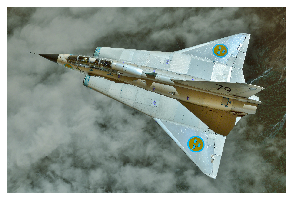

noisy image


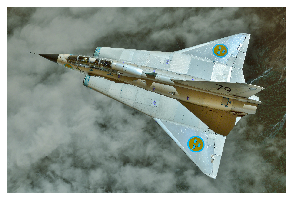

horiz sobel filter on noisy image (compare to above sobel and canny)


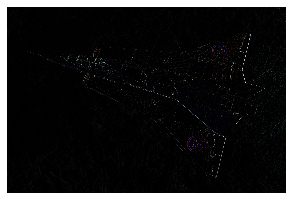

In [12]:
# noise
from skimage.util import random_noise
print("not noisy image")
display(image)
noisy = cv2.imread('../Filters/draken.jpg')
print("noisy image")
display(noisy)
print("horiz sobel filter on noisy image (compare to above sobel and canny)")
display(cv2.filter2D(image, -1, filter))

# more noise comes through in the image with edges, surprise surprise!
# I didn't run the canny filter on the noisy image, but it was good at reducing noise for the original